# Overview: Photometric Offsets

This notebook provides examples of how to use the results from `BruteForce` and some of the provided fuctions in `utils` to derive **photometric offsets** between a given set of models and data across several datasets as well as how to visualize them.

The file used in this notebook is publicly available and can be downloaded from the Dataverse at [this link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/5D3SHF).

# Preamble

As always, let's just set up a nice environment to run these tests.

In [1]:
from __future__ import print_function, division
from six.moves import range
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import h5py

In [2]:
# plot in-line within the notebook
%matplotlib inline

# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

In [3]:
import brutus

# All-Sky Data

The data we will use is taken from high-Galactic latitude slices with $|b| > 60$ and with extremely high parallax SNR (> 50). These are collected separately in the north and south.

In [4]:
from brutus import filters as flt

# load in data (north)
fdata1 = np.load('../data/calibration/gall_b+60.0_+90.0_highSNR.npz')

# load in data (south)
fname2 = 'gall_b-90.0_-60.0_highSNR'
filename2 = '../data/calibration/' + fname2
fdata2 = np.load('../data/calibration/gall_b-90.0_-60.0_highSNR.npz')

filters = fdata1['filters']  # filters
filters[:3] = flt.gaia  # rename Gaia filters, which have changed since catalog creation
info = np.append(fdata1['info'], fdata2['info'])  # object info
clean = info['GAIA_DR2_clean']  # clean mask

# remove bad objects
info = info[clean]
phot = np.append(fdata1['phot'], fdata2['phot'], axis=0)[clean]  # photometry
err = np.append(fdata1['err'], fdata2['err'], axis=0)[clean]  # error
mask = np.append(fdata1['mask'], fdata2['mask'], axis=0)[clean]  # mask
mask *= -2.5 * np.log10(phot) < 50.

# get info
parallax = info['GAIA_DR2_parallax']
parallax += 0.054  # add zero-point offset (SME19)
parallax_err = info['GAIA_DR2_parallax_err']
coords = np.c_[info['GAIA_DR2_l'], info['GAIA_DR2_b']]

# Gaia magnitudes
g, bp, rp = -2.5 * np.log10(phot[:, :3]).T + 5. * np.log10(parallax) - 10.

/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10
/home/joshspeagle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


In [5]:
# print summary
Nobj = len(info)
nbands, nbands_counts = np.unique(np.sum(mask, axis=1), return_counts=True)
print('Number of objects:', Nobj)
print('{0} total filters:'.format(len(filters)), filters)
print('Obj/filter:', np.sum(mask, axis=0))
print('Number of observed filters: ', nbands)
print('Corresponding object counts:', nbands_counts)

Number of objects: 289631
26 total filters: ['Gaia_G_MAW' 'Gaia_BP_MAWf' 'Gaia_RP_MAW' 'SDSS_u' 'SDSS_g' 'SDSS_r'
 'SDSS_i' 'SDSS_z' 'PS_g' 'PS_r' 'PS_i' 'PS_z' 'PS_y' 'DECam_g' 'DECam_r'
 'DECam_i' 'DECam_z' 'DECam_Y' '2MASS_J' '2MASS_H' '2MASS_Ks' 'UKIDSS_J'
 'UKIDSS_H' 'UKIDSS_K' 'WISE_W1' 'WISE_W2']
Obj/filter: [289631 289631 289631  87991  88064  88133  88088  88078 155246 133193
 128875 137284 167003  68638  43159  22252  17110  78161 107910 107941
 107933  33037  33284  33449 257264 257216]
Number of observed filters:  [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Corresponding object counts: [ 3404  3211 31577 13004 12161 38244 15479 46022 11228  9568 23383  8754
 18737  7855  7436 24940  2265  3421  7740   369   550   189    42    52]


Let's see what this data looks like.

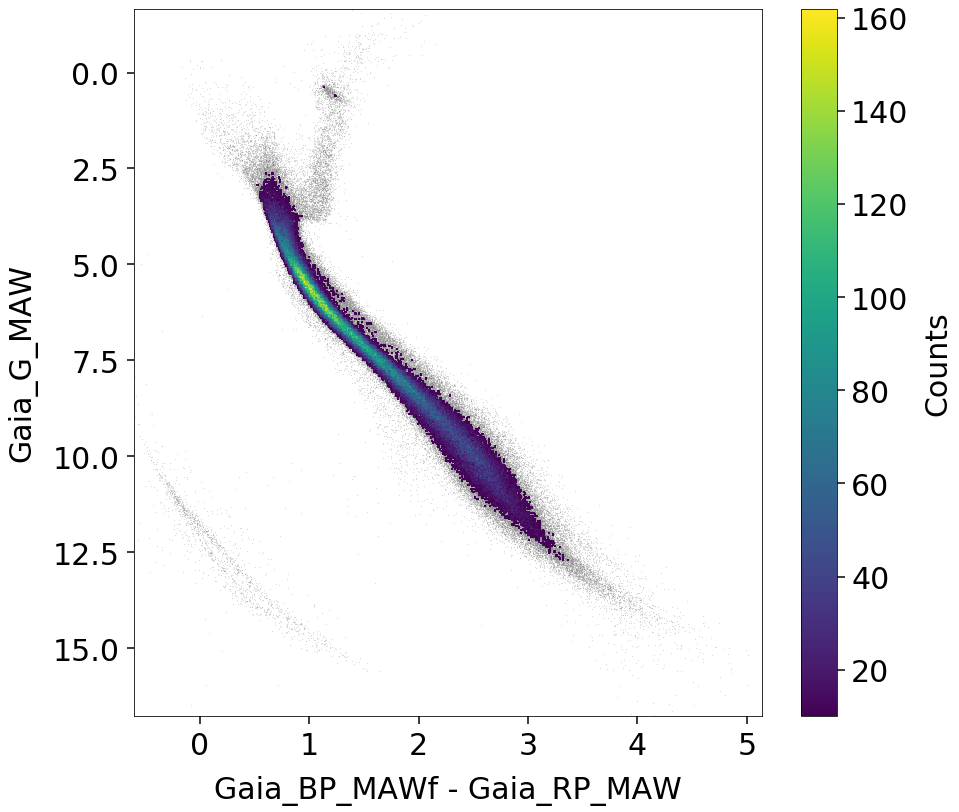

In [6]:
# plot Gaia CMD
plt.figure(figsize=(14, 12))
plt.plot(bp - rp, g, '.', ms=0.2, color='gray', zorder=1)
plt.hist2d(bp - rp, g, bins=500, cmin=10, zorder=2)
plt.xlabel(flt.gaia[1] + ' - ' + flt.gaia[2])
plt.ylabel(flt.gaia[0])
plt.gca().invert_yaxis()
plt.colorbar(label='Counts')
plt.tight_layout()

We define a subset of sources based on coverage in the Pan-STARRS and 2MASS surveys (the former limits our data to the North) that we will actually use in the fit. All other bands will have photometry that is *predicted* based on the fits in these bands.

We also remove sources which are estimated to be below $\sim 0.5 M_\odot$, for which the MIST models do not perform as well.

In [7]:
# subselect over PS+2MASS
filters_fit = flt.ps[:-2] + flt.tmass
outmask = np.array(mask)
for i, f in enumerate(filters):
    if f not in flt.ps[:-2] + flt.tmass:
        outmask[:, i] = False
sel = np.sum(outmask, axis=1) == len(flt.ps[:-2] + flt.tmass)
        
# remove white dwarfs
gmcut = g < np.poly1d([4., 6.])(bp - rp)
sel *= gmcut

# subselect data to be above M ~ 0.55
gmcut = g < np.poly1d([-0.05191383, 1.88017597, 4.96841141])(bp-rp)
sel *= gmcut
        
        
# define quantities
info = info[sel]
phot = phot[sel]
err = err[sel]
mask, outmask = mask[sel], outmask[sel]
parallax = parallax[sel]
parallax_err = parallax_err[sel]
coords = coords[sel]

In [8]:
# print summary
Nobj = len(info)
nbands, nbands_counts = np.unique(np.sum(mask, axis=1), return_counts=True)
print('Number of objects:', Nobj)
print('{0} total filters:'.format(len(filters)), filters)
print('Obj/filter:', np.sum(mask, axis=0))
print('Number of observed filters: ', nbands)
print('Corresponding object counts:', nbands_counts)

Number of objects: 23324
26 total filters: ['Gaia_G_MAW' 'Gaia_BP_MAWf' 'Gaia_RP_MAW' 'SDSS_u' 'SDSS_g' 'SDSS_r'
 'SDSS_i' 'SDSS_z' 'PS_g' 'PS_r' 'PS_i' 'PS_z' 'PS_y' 'DECam_g' 'DECam_r'
 'DECam_i' 'DECam_z' 'DECam_Y' '2MASS_J' '2MASS_H' '2MASS_Ks' 'UKIDSS_J'
 'UKIDSS_H' 'UKIDSS_K' 'WISE_W1' 'WISE_W2']
Obj/filter: [23324 23324 23324 17756 17754 17769 17757 17760 23324 23324 23324 23324
 23324  4526  1547   135   176  4839 23324 23324 23324  4817  4906  4950
 22933 22933]
Number of observed filters:  [11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Corresponding object counts: [   78     4  2173   402  1753  1144   194 11238   262  1153  4549    91
   203    80]


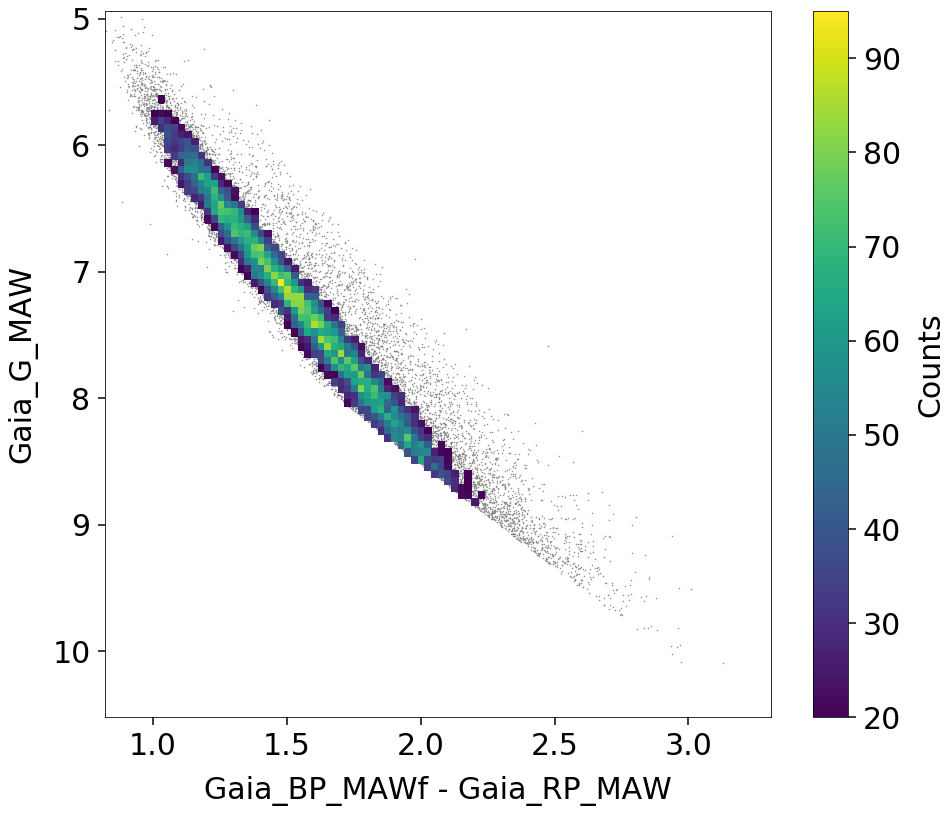

In [9]:
# plot Gaia CMD
plt.figure(figsize=(14, 12))
plt.plot((bp - rp)[sel], g[sel], '.', ms=1, color='gray', zorder=1)
plt.hist2d((bp - rp)[sel], g[sel], bins=100, cmin=20, zorder=2)
plt.xlabel(flt.gaia[1]+' - '+flt.gaia[2])
plt.ylabel(flt.gaia[0])
plt.gca().invert_yaxis()
plt.colorbar(label='Counts')
plt.tight_layout()

# Bayestar Models

To illustrate the procedure, we first examine how to derive photometric offsets for the **"Bayestar" models**. These are empirical stellar models built using Pan-STARRS and 2MASS data, and so we expect that any photometric offsets should be small by construction.

In [14]:
from brutus import utils as butils

# import Bayestar models
filepath = '../data/DATAFILES/grid_bayestar_v5.h5'
models_bs, labels_bs, lmask_bs = butils.load_models(filepath, filters=filters_fit)

fsel = [np.where(f == filters)[0][0] for f in filters_fit]  # select only PS+2MASS

Reading filter 2MASS_Ks           


We will also load the previously-derived photometric offsets.

In [15]:
# load offsets
offsets_bs = butils.load_offsets('../data/DATAFILES/offsets_bs_v5.txt',
                                 filters=filters_fit)

PS_g (-2.0%)
PS_r (-2.0%)
PS_i (-1.0%)
PS_z (0.0%)
PS_y (0.0%)
2MASS_J (0.0%)
2MASS_H (1.0%)
2MASS_Ks (1.0%)


We can now go ahead and actually fit the data using the `BruteForce` class. See a previous notebook for a tutorial on how this works. Note that the runtimes here are much lower than average due to the strong parallax constraints.

In [12]:
from brutus.fitting import BruteForce

# define fitter
BF_bs = BruteForce(models_bs, labels_bs, lmask_bs)

In [13]:
dustfile = '../data/DATAFILES/bayestar2019_v1.h5'  # 3-D dust map

# fit Bayestar models to data
BF_bs.fit(phot[:, fsel], err[:, fsel], 
          outmask[:, fsel], 
          info, 'calib_allsky_bs_v5',
          phot_offsets=offsets_bs,
          parallax=parallax, parallax_err=parallax_err,
          data_coords=coords,
          dustfile=dustfile)

Fitting object 23324/23324 [chi2/n: 4.6/9] (mean time: 0.091 s/obj, est. time remaining:      0.000 s)    


Let's now load the results see how the fits look.

In [16]:
from scipy import stats

# load results
f = h5py.File('calib_allsky_bs_v5.h5', 'r')
idxs_bs = f['model_idx'][:]
chi2_bs = f['obj_chi2min'][:]
nbands_bs = f['obj_Nbands'][:]
dists_bs = f['samps_dist'][:]
reds_bs = f['samps_red'][:]
dreds_bs = f['samps_dred'][:]
lnps_bs = f['samps_logp'][:]

# check number of good fits
good_bs = stats.chi2.sf(chi2_bs, nbands_bs - 3) > 1e-3
Ngood_bs = sum(good_bs)
print('Good fits: {0}/{1} [{2}%]'.format(Ngood_bs, len(good_bs), 
                                         100. * Ngood_bs / len(good_bs)))

Good fits: 22702/23324 [97.33321900188646%]


Great! So a vast majority of the stars are well-modeled. We can see a typical SED below.

Best-fit chi2: 2.8586462


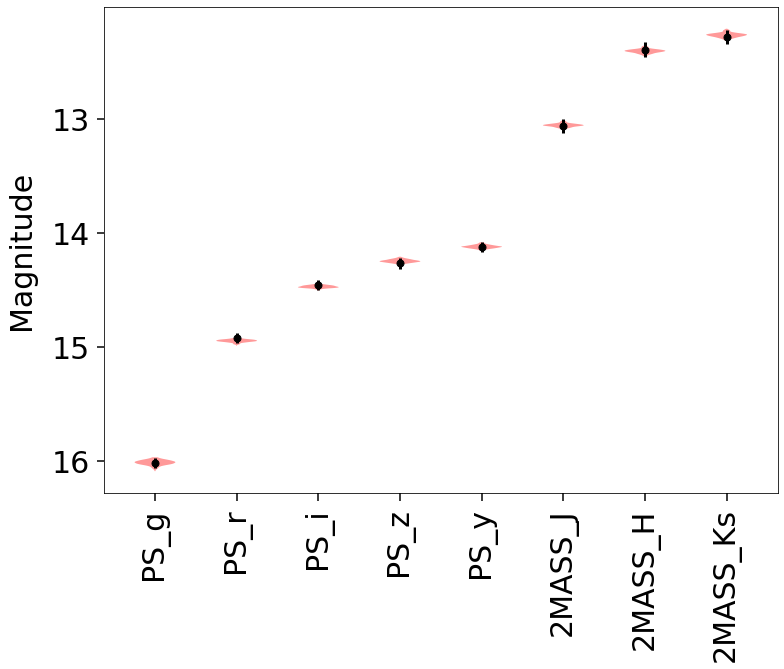

In [17]:
from brutus import plotting as bplot

i = 2  # index of object

# plot SED (posterior predictive)
bplot.posterior_predictive(models_bs, idxs_bs[i], 
                           reds_bs[i], dreds_bs[i], dists_bs[i], 
                           data=phot[i, fsel], data_err=err[i, fsel], 
                           data_mask=mask[i, fsel], 
                           offset=offsets_bs, labels=filters_fit,
                           vcolor='red')
print('Best-fit chi2:', chi2_bs[i])

# Photometric Offsets

Photometric offsets between the data and the models (averaged over unknown reddening and stellar properties) can be computed using the `photometric_offsets` function in the `utils` module. This essentially computes the predicted offset in each band assuming it wasn't included in the fit. It "averages" over the hypothetical posterior using a combination of reweighting and Monte Carlo resampling. See the documentation for additional details.

In [16]:
from brutus.utils import photometric_offsets

# prior on offsets
prior_mean = np.ones(len(filters_fit))
prior_std = np.ones_like(prior_mean) * 5e-3


off, off_err, off_n = photometric_offsets(phot[:, fsel], err[:, fsel], mask[:, fsel],
                                          models_bs, idxs_bs, 
                                          reds_bs, dreds_bs, dists_bs,
                                          sel=good_bs,  # only use well-fit objects
                                          old_offsets=offsets_bs,  # old offsets used in fits
                                          prior_mean=prior_mean, prior_std=prior_std)  # priors

Band 8 (150/150)     


In [17]:
for f, o in zip(filters_fit, off):
    print(f, o)

PS_g 0.9783653872779761
PS_r 0.9766445875853631
PS_i 0.986304461507759
PS_z 0.9963237519108055
PS_y 1.0045313407061447
2MASS_J 1.0017530543876316
2MASS_H 1.0117140140304155
2MASS_Ks 1.0143282591936857


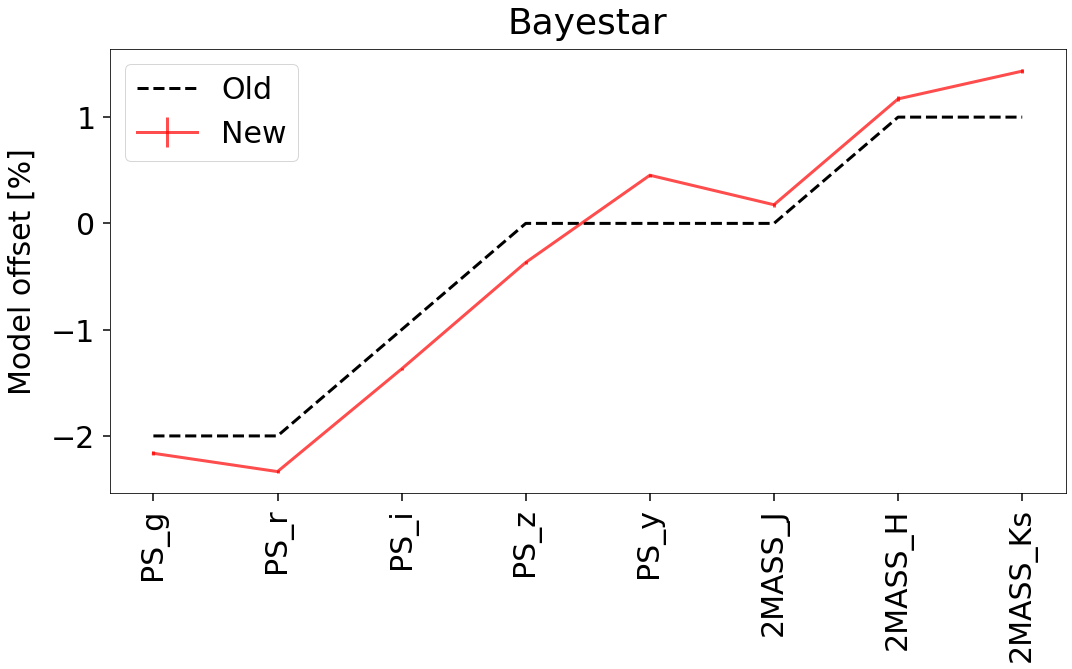

In [18]:
# plot offsets
plt.figure(figsize=(16, 10))
plt.errorbar(np.arange(len(filters_fit)), (off - 1.) * 100.,
             yerr=off_err * 100, lw=3, color='red', alpha=0.7,
             label='New')
plt.plot((offsets_bs - 1.) * 100., lw=3, ls='--', 
         color='black', label='Old')
plt.legend(fontsize='medium')
plt.xticks(np.arange(len(filters_fit)), filters_fit, rotation='vertical')
plt.ylabel('Model offset [%]')
plt.title('Bayestar')
plt.tight_layout()

Note that since offsets are rounded to the nearest percent, small deviations are expected.

There are some additional built-in plotting utilities to help visualize what these offsets look like. One example is the `photometric_offsets` plotting function in the `plotting` module, which allows users to plot the distribution of offsets against various features.

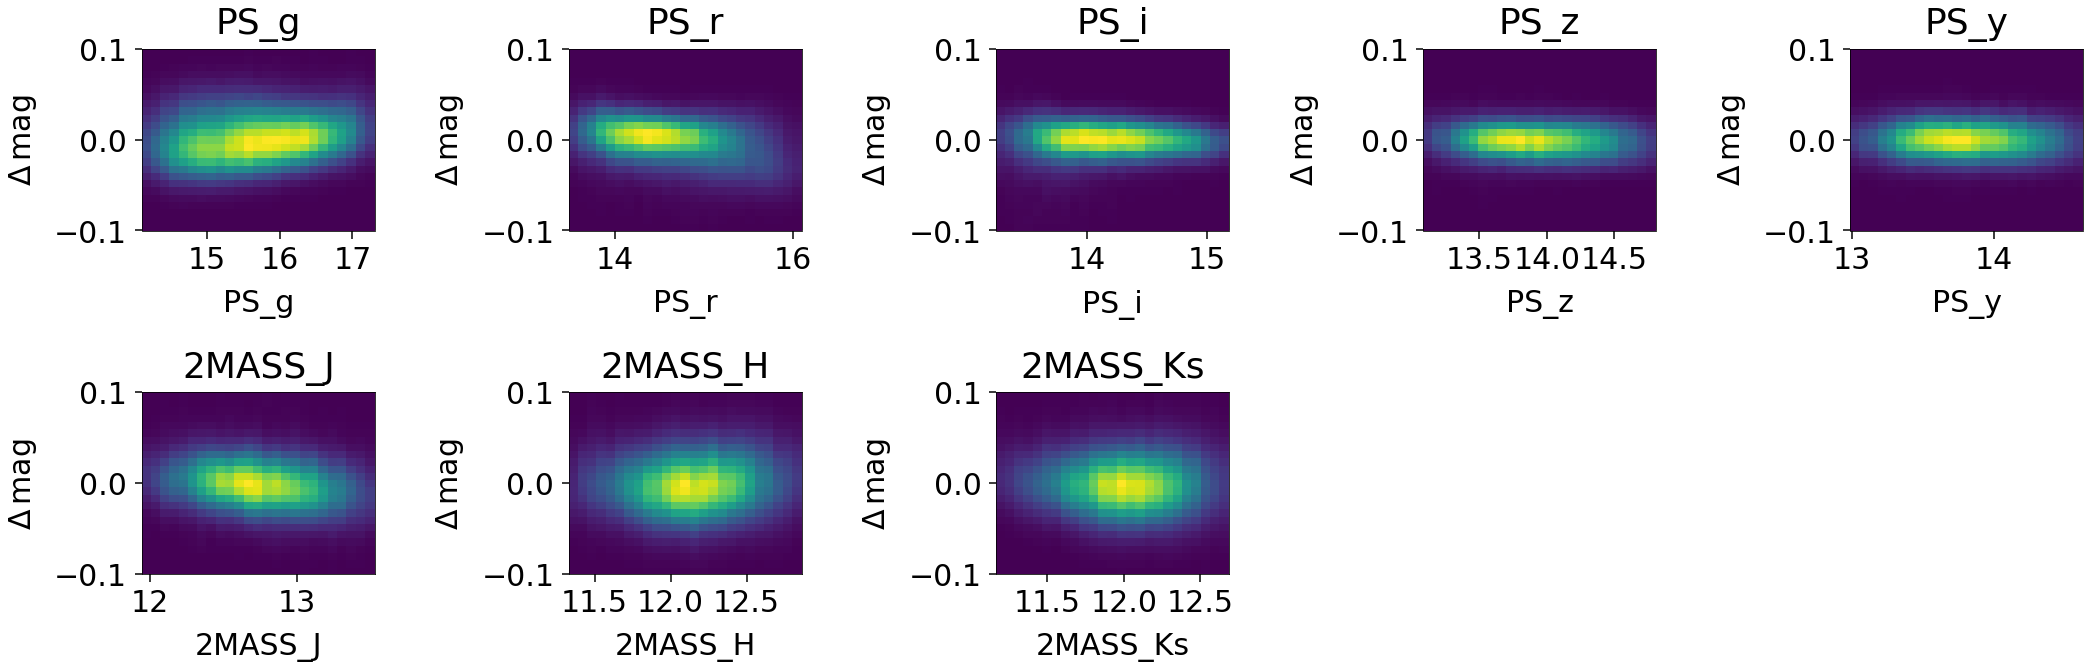

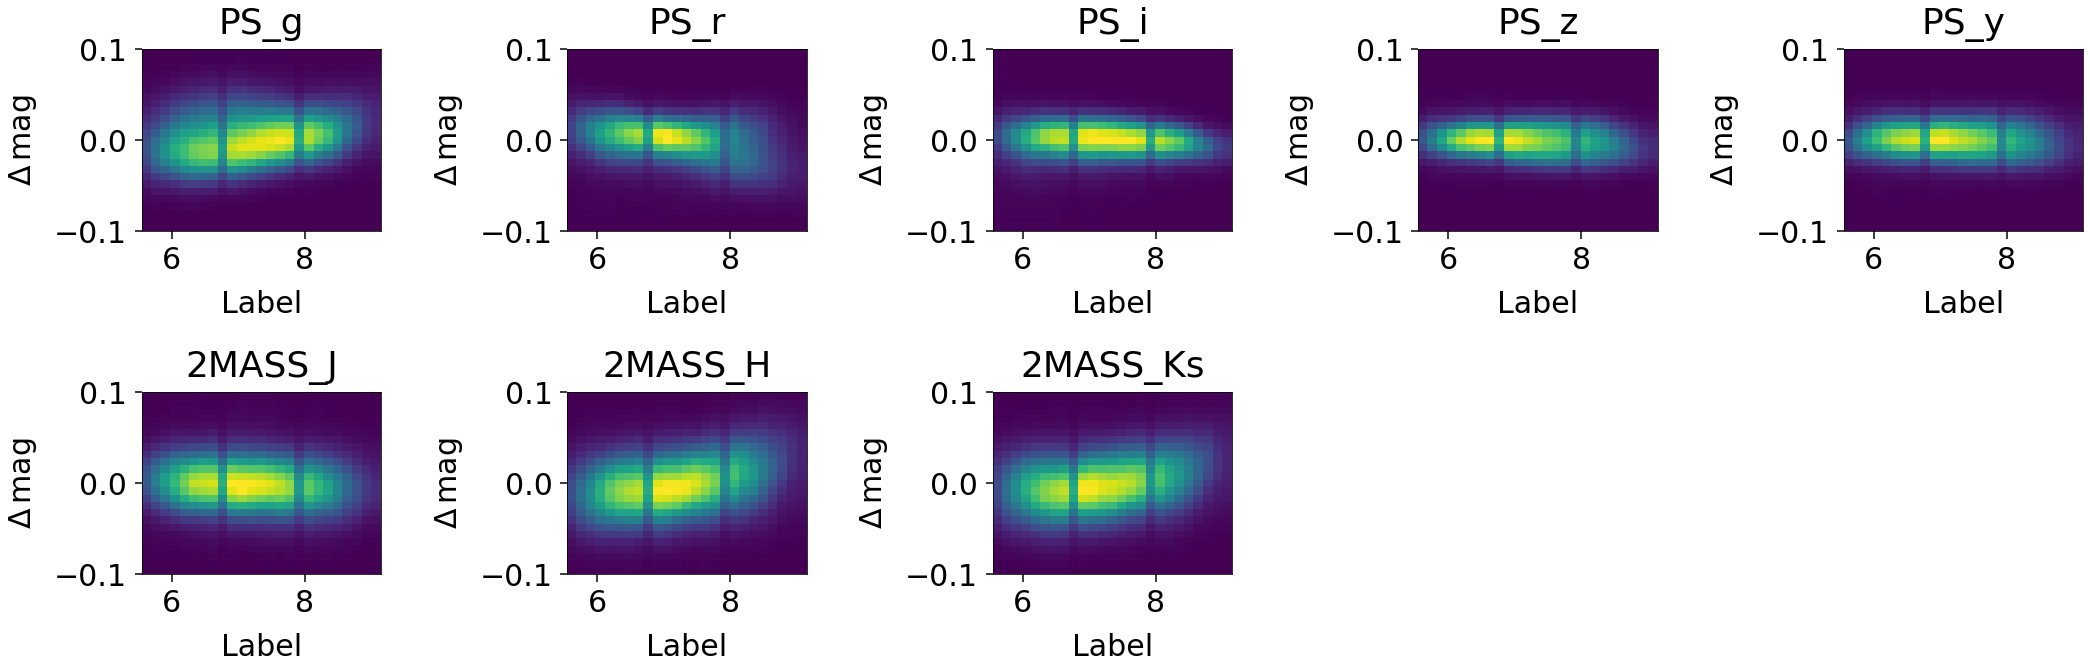

In [19]:
# set same bounds on all plots
yspan = [(-0.1, 0.1) for i,_ in enumerate(filters_fit)]

# plot as function of magnitude (default)
fig, ax = bplot.photometric_offsets(phot[:, fsel], err[:, fsel], mask[:, fsel],
                                    models_bs, idxs_bs, reds_bs, dreds_bs, dists_bs, 
                                    weights=good_bs,  # only plot good fits
                                    offset=off,  # shift by offsets
                                    titles=filters_fit,
                                    bins=25, yspan=yspan)

# plot as function of Mr
fig, ax = bplot.photometric_offsets(phot[:, fsel], err[:, fsel], mask[:, fsel],
                                    models_bs, idxs_bs, reds_bs, dreds_bs, dists_bs, 
                                    x=labels_bs['Mr'][idxs_bs],  # switch x-axis
                                    weights=good_bs,  # only plot good fits
                                    offset=off,  # shift by offsets
                                    titles=filters_fit,
                                    bins=25, yspan=yspan)

We see these display a small amount of structure, but in general are pretty flat. Note that the aliasing in the bottom panel is due to a mismatch between the bins and the grid in $M_r$.

Finally, one other way to visualize these offsets is to look at how they vary as a function of position across the color-magnitude diagram (CMD). This can be done with the `photometric_offsets_2d` function in `plotting`, which allows users to visualize the offsets as a function of arbitrary x and y (in this case color and magnitude).

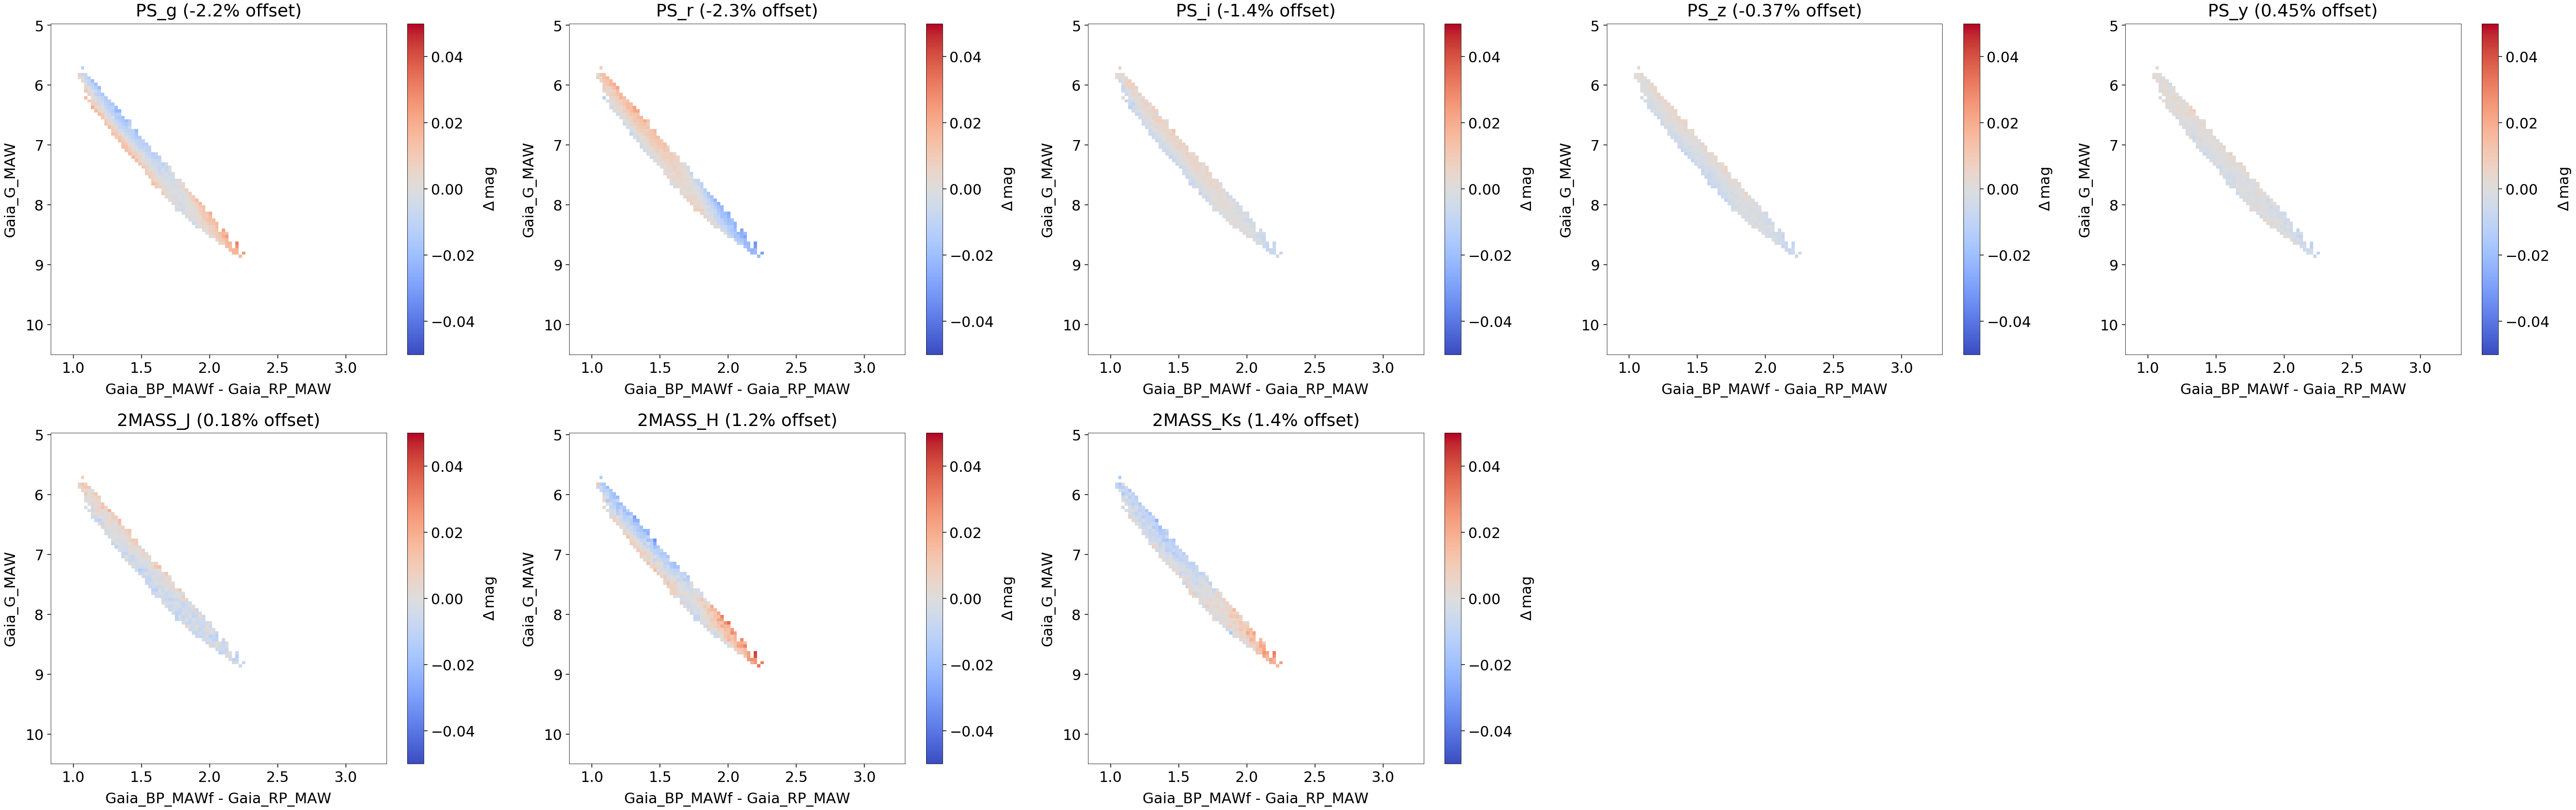

In [20]:
bins = 100  # number of bins
bins_min = 20.  # minimum number of objects to plot bin

# photometric offsets
fig, ax = bplot.photometric_offsets_2d(phot[:, fsel], err[:, fsel], mask[:, fsel],
                                       models_bs, idxs_bs, reds_bs, dreds_bs, dists_bs,
                                       (bp-rp)[sel], g[sel],  # color and magnitude
                                       bins=bins, plot_thresh=bins_min, 
                                       offset=off,
                                       titles=filters_fit,
                                       xlabel=flt.gaia[1]+' - '+flt.gaia[2],
                                       ylabel=flt.gaia[0])
[a.set_ylim(a.get_ylim()[::-1]) for a in ax.flatten()];

# MIST Calibration

We can now run through the same thing for the MIST models.

In [11]:
from brutus import utils as butils

# import MIST models
filepath = '../data/DATAFILES/grid_mist_v9.h5'
models_mist, labels_mist, lmask_mist = butils.load_models(filepath, filters=filters)

Reading filter WISE_W2                


In [25]:
# load offsets
offsets_mist = butils.load_offsets('../data/DATAFILES/offsets_mist_v9.txt',
                                   filters=filters)

Gaia_G_MAW (1.0%)
Gaia_BP_MAWf (1.0%)
Gaia_RP_MAW (-3.0%)
SDSS_u (5.0%)
SDSS_g (1.0%)
SDSS_r (-1.0%)
SDSS_i (-5.0%)
SDSS_z (-6.0%)
PS_g (0.0%)
PS_r (-5.0%)
PS_i (-4.0%)
PS_z (-6.0%)
PS_y (-5.0%)
DECam_g (0.0%)
DECam_r (-5.0%)
DECam_i (-4.0%)
DECam_z (-6.0%)
DECam_Y (-5.0%)
2MASS_J (-2.0%)
2MASS_H (4.0%)
2MASS_Ks (3.0%)
UKIDSS_J (-2.0%)
UKIDSS_H (4.0%)
UKIDSS_K (4.0%)
WISE_W1 (2.0%)
WISE_W2 (3.0%)


In [14]:
from brutus.fitting import BruteForce

# define fitter
BF_mist = BruteForce(models_mist, labels_mist, lmask_mist)

In [16]:
dustfile = '../data/DATAFILES/bayestar2019_v1.h5'

# fit MIST models to data
BF_mist.fit(phot, err, 
            outmask,  # mask all non PS+2MASS bands
            info, 'calib_allsky_mist_v9',
            phot_offsets=offsets_mist,
            parallax=parallax, parallax_err=parallax_err,
            data_coords=coords,
            dustfile=dustfile)

Fitting object 23324/23324 [chi2/n: 1.3/9] (mean time: 0.859 s/obj, est. time remaining:      0.000 s)    


In [17]:
from scipy import stats

# load results
f = h5py.File('calib_allsky_mist_v9.h5', 'r')
idxs_mist = f['model_idx'][:]
chi2_mist = f['obj_chi2min'][:]
nbands_mist = f['obj_Nbands'][:]
dists_mist = f['samps_dist'][:]
reds_mist = f['samps_red'][:]
dreds_mist = f['samps_dred'][:]
lnps_mist = f['samps_logp'][:]

# check number of good fits
good_mist = stats.chi2.sf(chi2_mist, nbands_mist - 3) > 1e-3
Ngood_mist = sum(good_mist)
print('Good fits: {0}/{1} [{2}%]'.format(Ngood_mist, len(good_mist), 
                                         100. * Ngood_mist / len(good_mist)))

Good fits: 22572/23324 [96.77585319842223%]


Let's now examine the fits. Note that now we are able to predict a variety of other bandpasses, we can see how well our models are able to interpolate/extrapolate.

Best-fit chi2: 3.078715


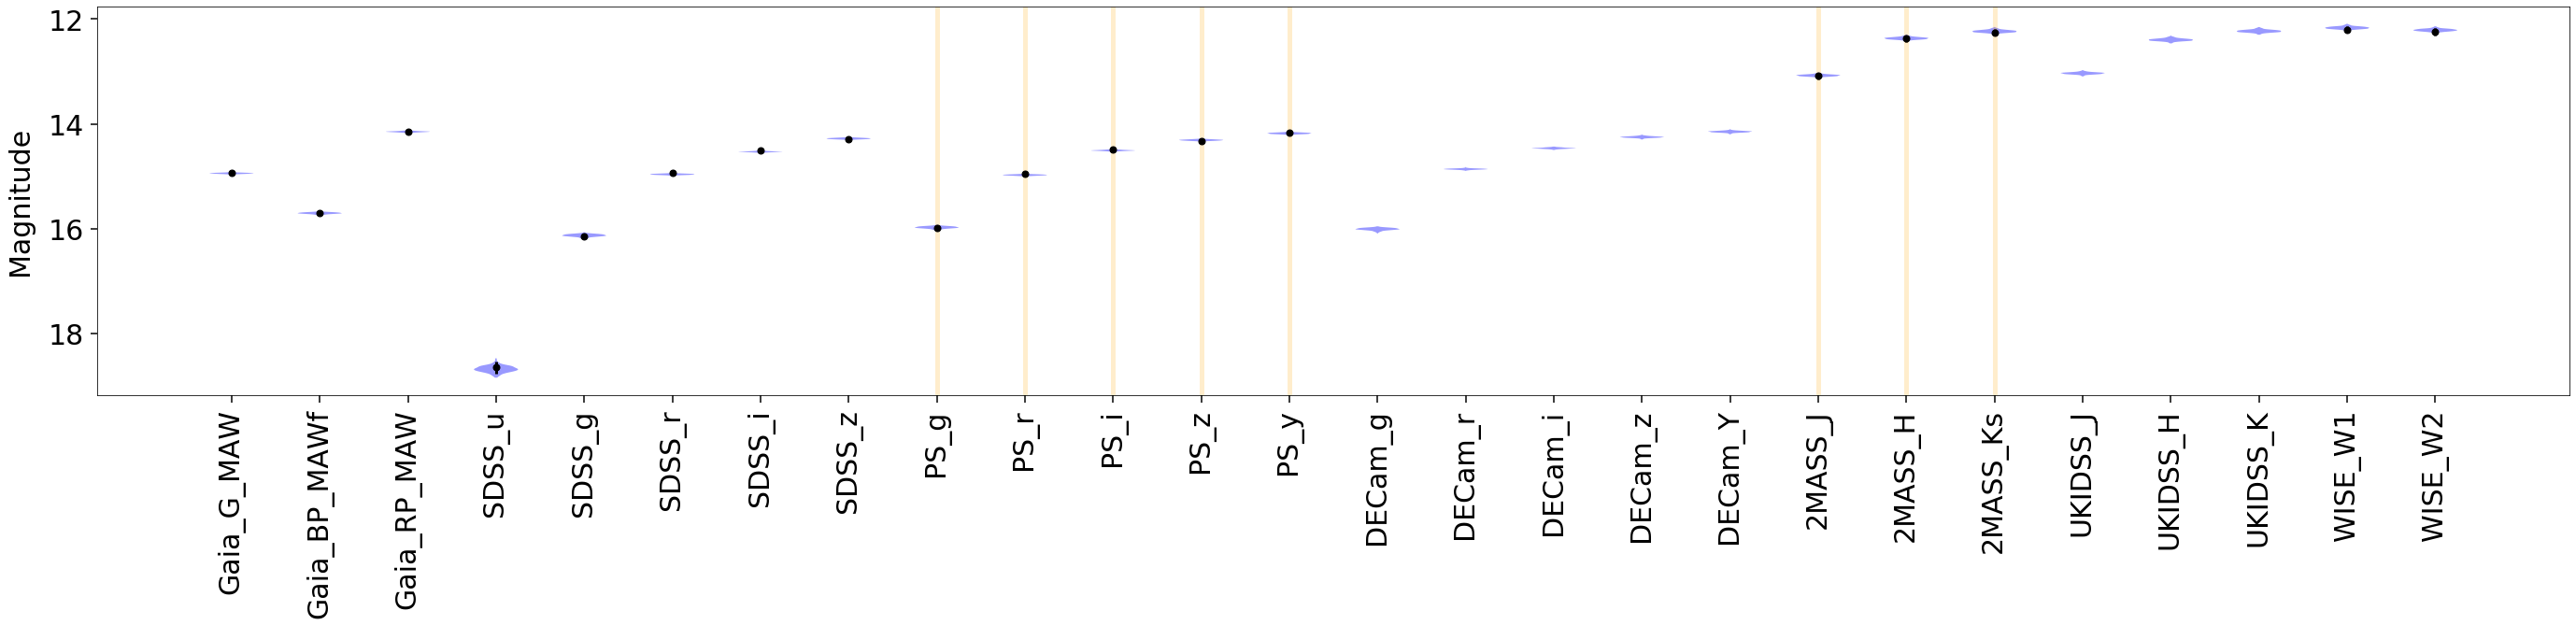

In [19]:
from brutus import plotting as bplot

i = 2  # index of object
print('Best-fit chi2:', chi2_mist[i])

# plot SED (posterior predictive)
bplot.posterior_predictive(models_mist, idxs_mist[i], 
                           reds_mist[i], dreds_mist[i], dists_mist[i], 
                           data=phot[i], data_err=err[i], 
                           data_mask=mask[i], 
                           offset=offsets_mist, labels=filters,
                           vcolor='blue')
# highlight bands used in fit
fsel = [np.where(f == filters)[0][0] for f in filters_fit]  # select only PS+2MASS
plt.vlines(fsel, 10, 100, colors='orange', lw=5, alpha=0.2);

And now let's compute the photometric offsets!

In [20]:
from brutus.utils import photometric_offsets

# prior on offsets
prior_mean = np.ones(len(filters))
prior_std = np.ones_like(prior_mean) * 5e-3


off, off_err, off_n = photometric_offsets(phot, err, mask,
                                          models_mist, idxs_mist, 
                                          reds_mist, dreds_mist, dists_mist,
                                          mask_fit=np.any(outmask, axis=0),  # bands used in the fit
                                          sel=good_mist,  # only use well-fit objects
                                          old_offsets=offsets_mist,  # old offsets used in fits
                                          prior_mean=prior_mean, prior_std=prior_std)  # priors

Band 26 (150/150)     


In [21]:
for f, o, n in zip(filters, off, off_n):
    print(f, o, n)

Gaia_G_MAW 1.0147204609801366 22572
Gaia_BP_MAWf 1.0144864001382234 22572
Gaia_RP_MAW 0.9667203224055805 22572
SDSS_u 1.0503119358556088 17180
SDSS_g 1.0118046586254608 17177
SDSS_r 0.9895322675029302 17191
SDSS_i 0.9463846630401219 17180
SDSS_z 0.9397866323158395 17183
PS_g 1.0003678649655137 22572
PS_r 0.9486159658551137 22572
PS_i 0.9539489650505723 22572
PS_z 0.9419997357637723 22572
PS_y 0.9544006716847943 22572
DECam_g 1.0519536510933132 4442
DECam_r 0.9882940039594529 1527
DECam_i 0.9710201123585297 131
DECam_z 0.9738734111018381 174
DECam_Y 0.9979373492464333 4723
2MASS_J 0.9789989256664661 22572
2MASS_H 1.0371518957864743 22572
2MASS_Ks 1.0280703772668462 22572
UKIDSS_J 0.9798386725584693 4669
UKIDSS_H 1.0401832714768848 4757
UKIDSS_K 1.0428120791798148 4799
WISE_W1 1.0188851221665653 22256
WISE_W2 1.0250381582254993 22256


Note that since there is barely any DECam or UKIDSS data that overlaps with Pan-STARRS here, those offsets are almost entirely unconstrained. Those are derived elsewhere.

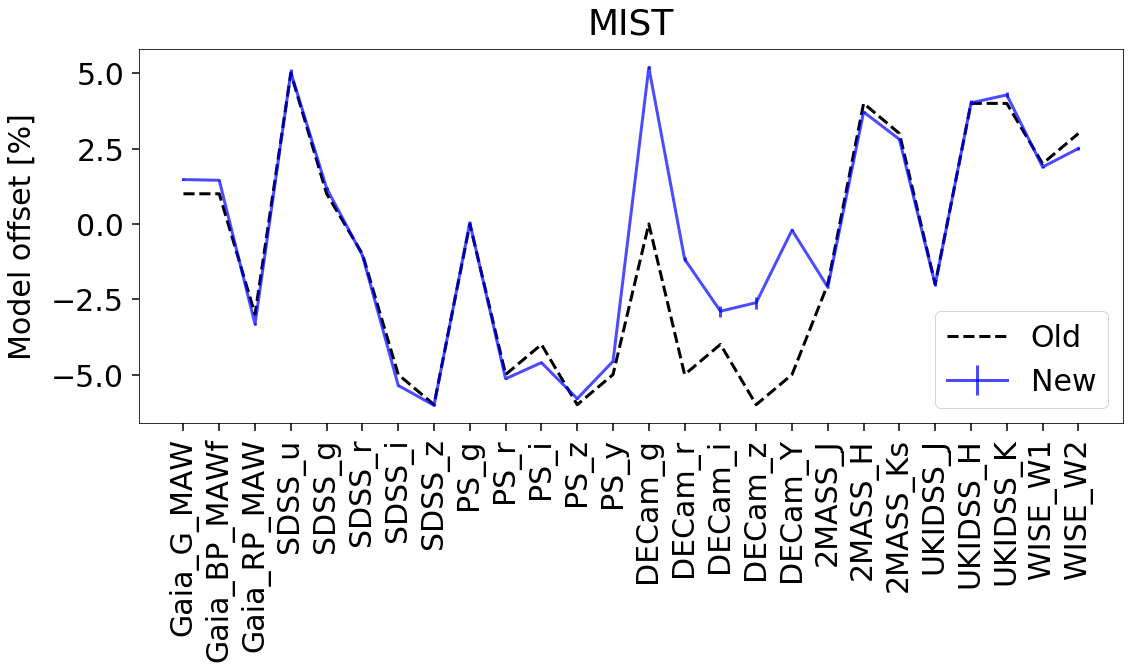

In [26]:
# plot offsets
plt.figure(figsize=(16, 10))
plt.errorbar(np.arange(len(filters)), (off - 1.) * 100.,
             yerr=off_err * 100, lw=3, color='blue', alpha=0.7,
             label='New')
plt.plot((offsets_mist - 1.) * 100., lw=3, ls='--', 
         color='black', label='Old')
plt.legend(fontsize='medium')
plt.xticks(np.arange(len(filters)), filters, rotation='vertical')
plt.ylabel('Model offset [%]')
plt.title('MIST')
plt.tight_layout()

As above, since offsets are rounded to the nearest percent, small deviations are expected.

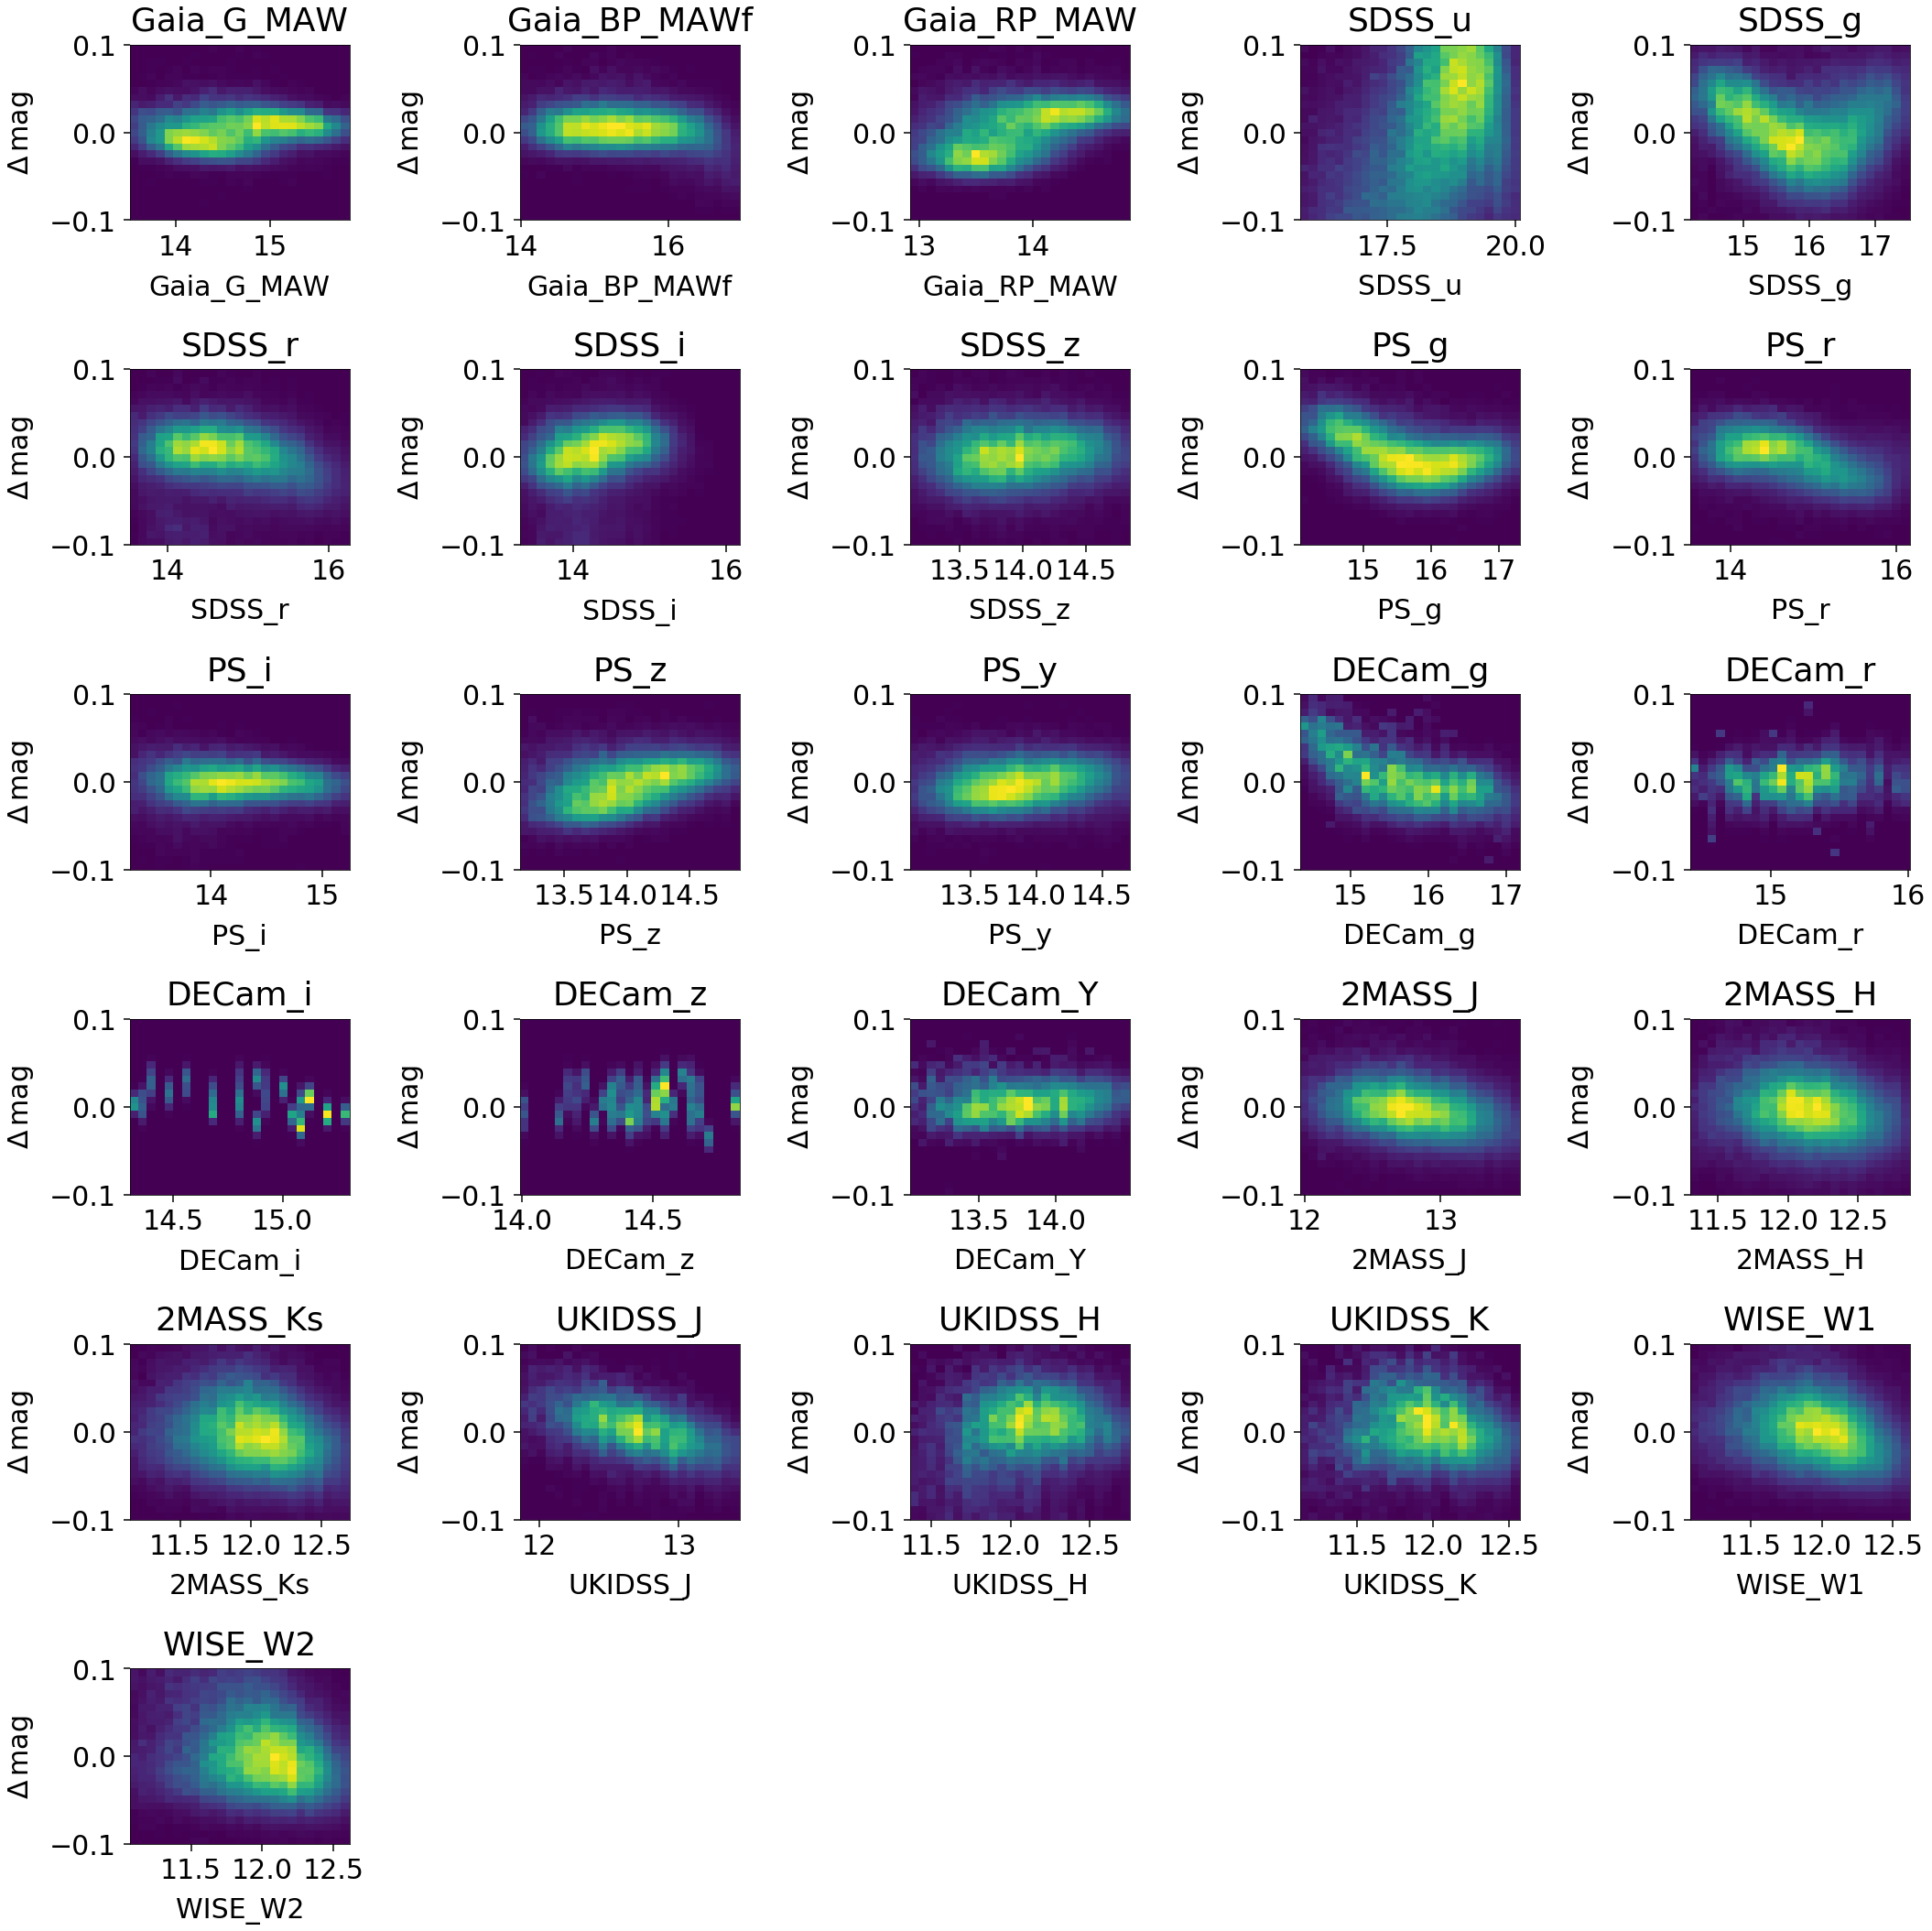

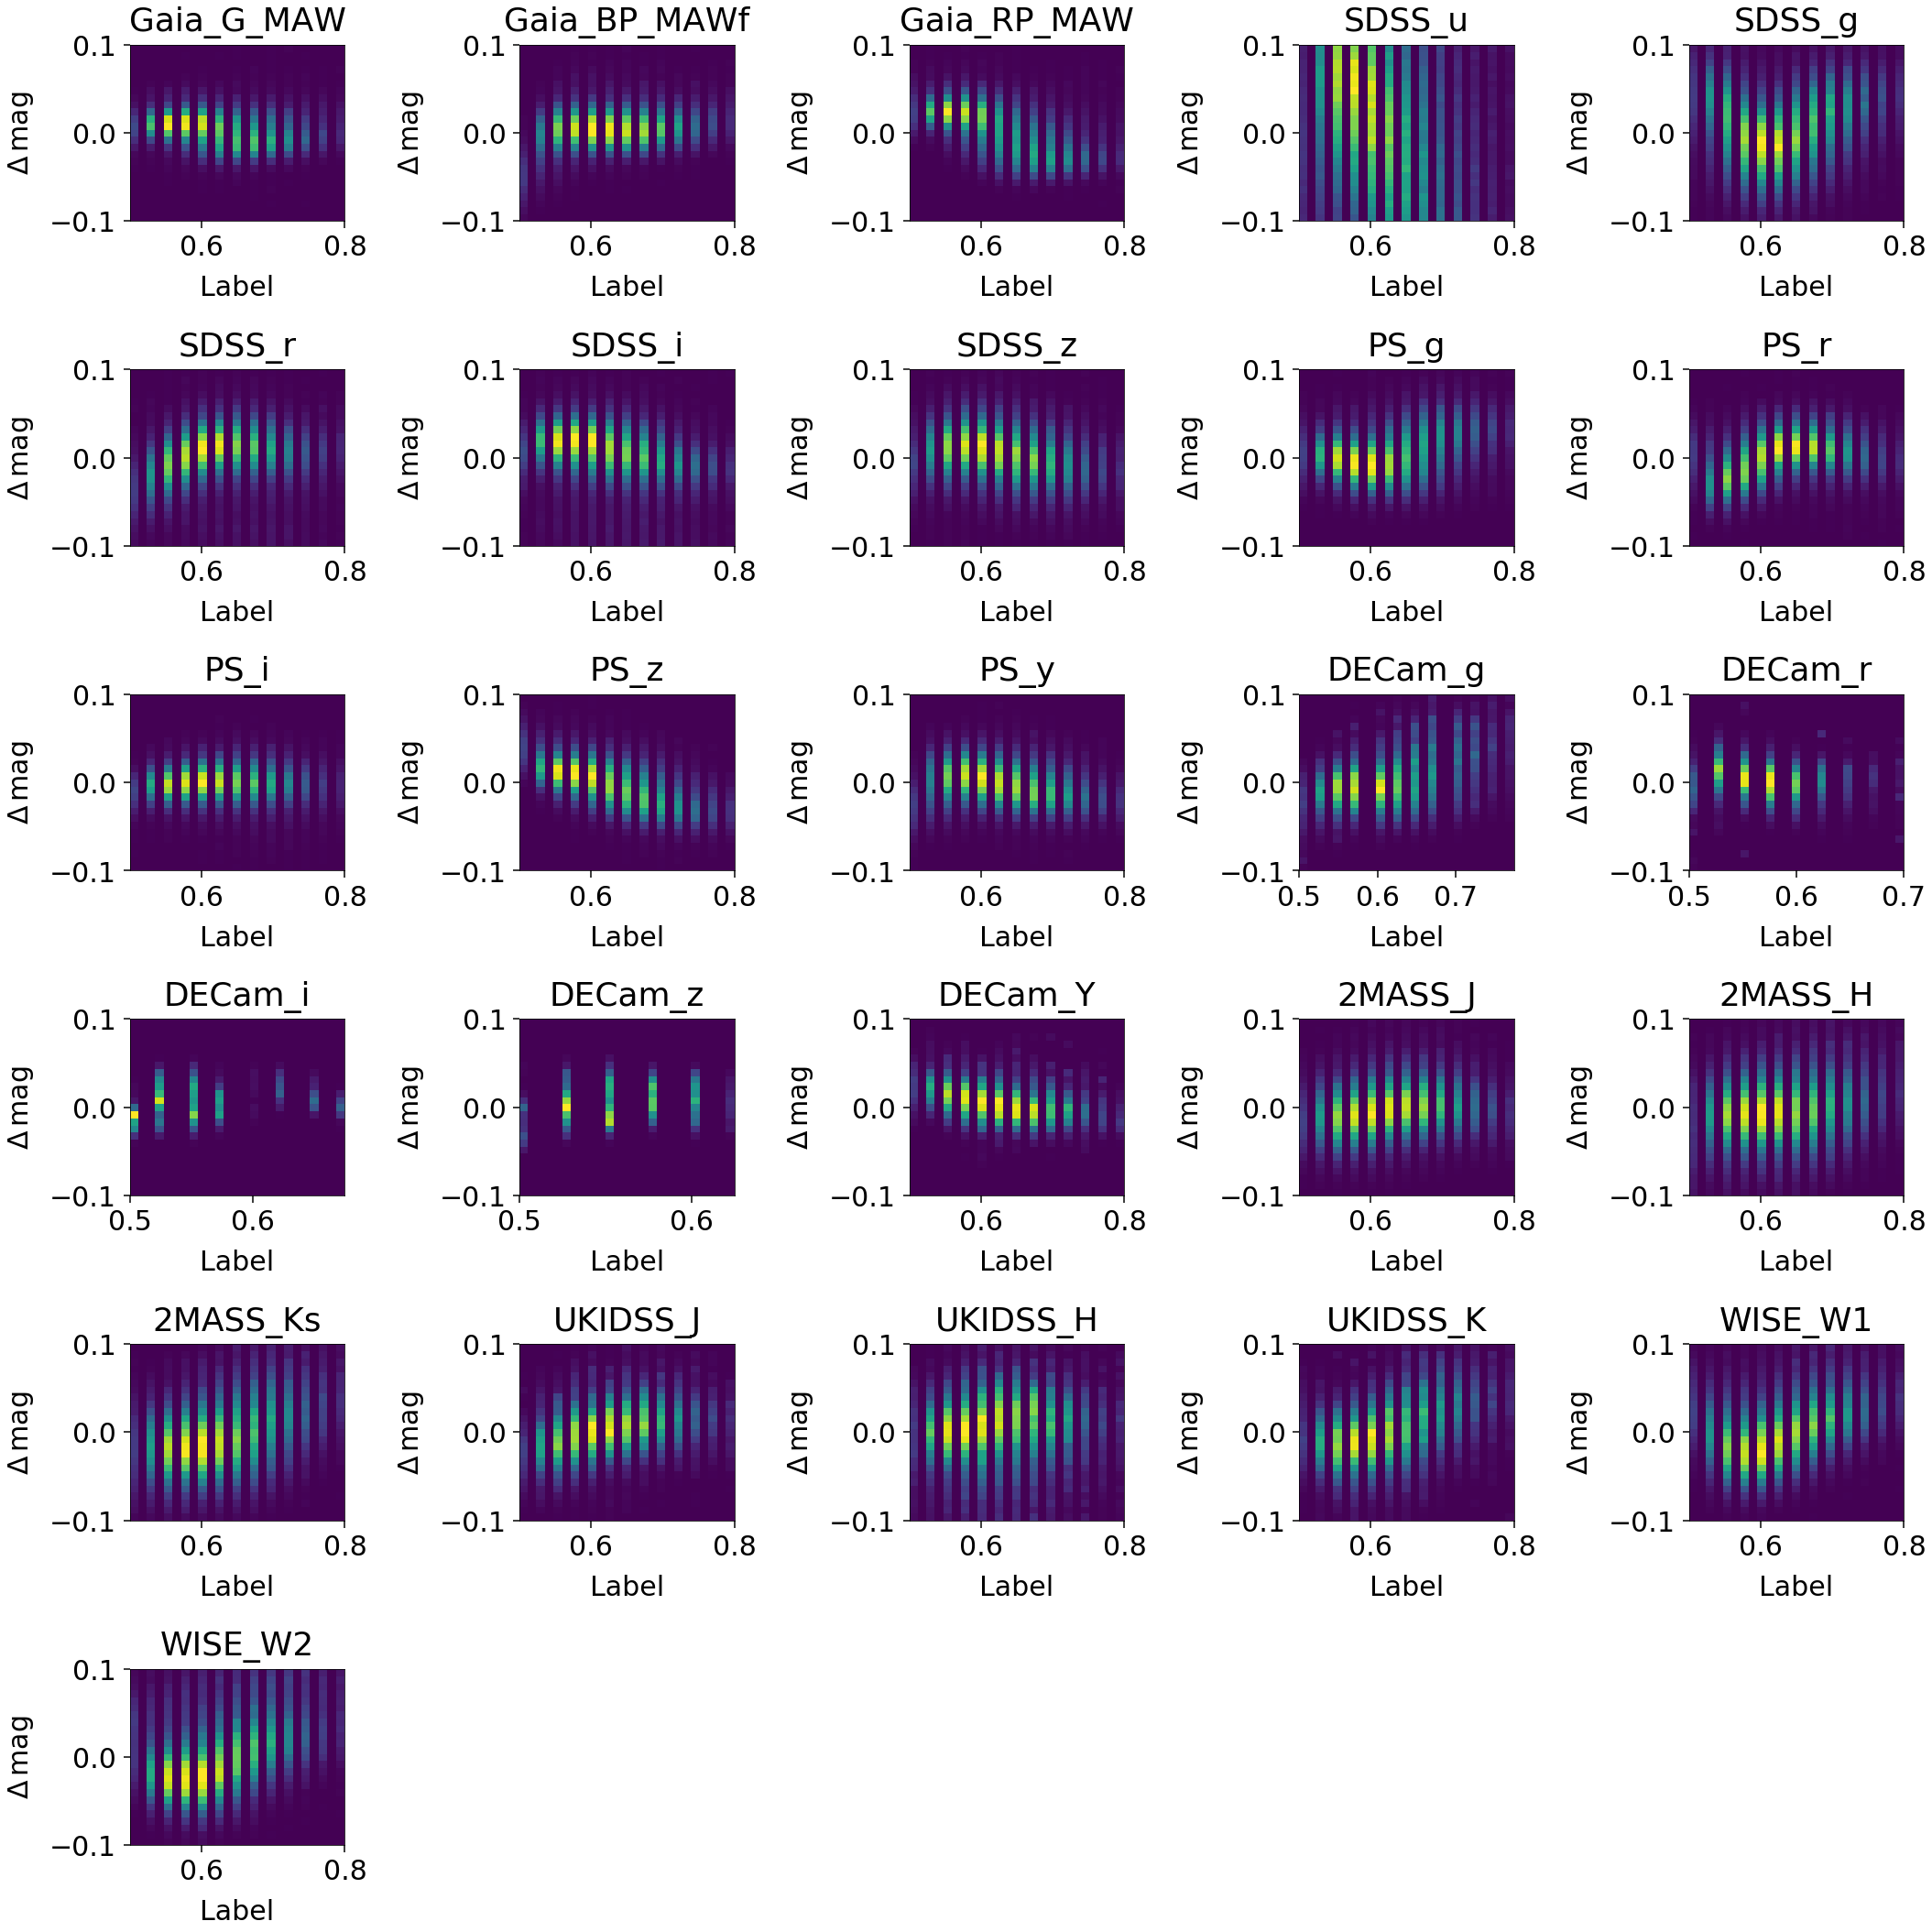

In [23]:
# set same bounds on all plots
yspan = [(-0.1, 0.1) for i,_ in enumerate(filters)]

# plot as function of magnitude (default)
fig, ax = bplot.photometric_offsets(phot, err, mask,
                                    models_mist, idxs_mist, 
                                    reds_mist, dreds_mist, dists_mist, 
                                    weights=good_mist,
                                    offset=off,
                                    titles=filters,
                                    bins=25, yspan=yspan)

# plot as function of mini
fig, ax = bplot.photometric_offsets(phot, err, mask,
                                    models_mist, idxs_mist, 
                                    reds_mist, dreds_mist, dists_mist, 
                                    x=labels_mist['mini'][idxs_mist],  # switch x-axis
                                    offset=off,
                                    titles=filters,
                                    bins=25, yspan=yspan)

We see these display much more structure than the previous fits.

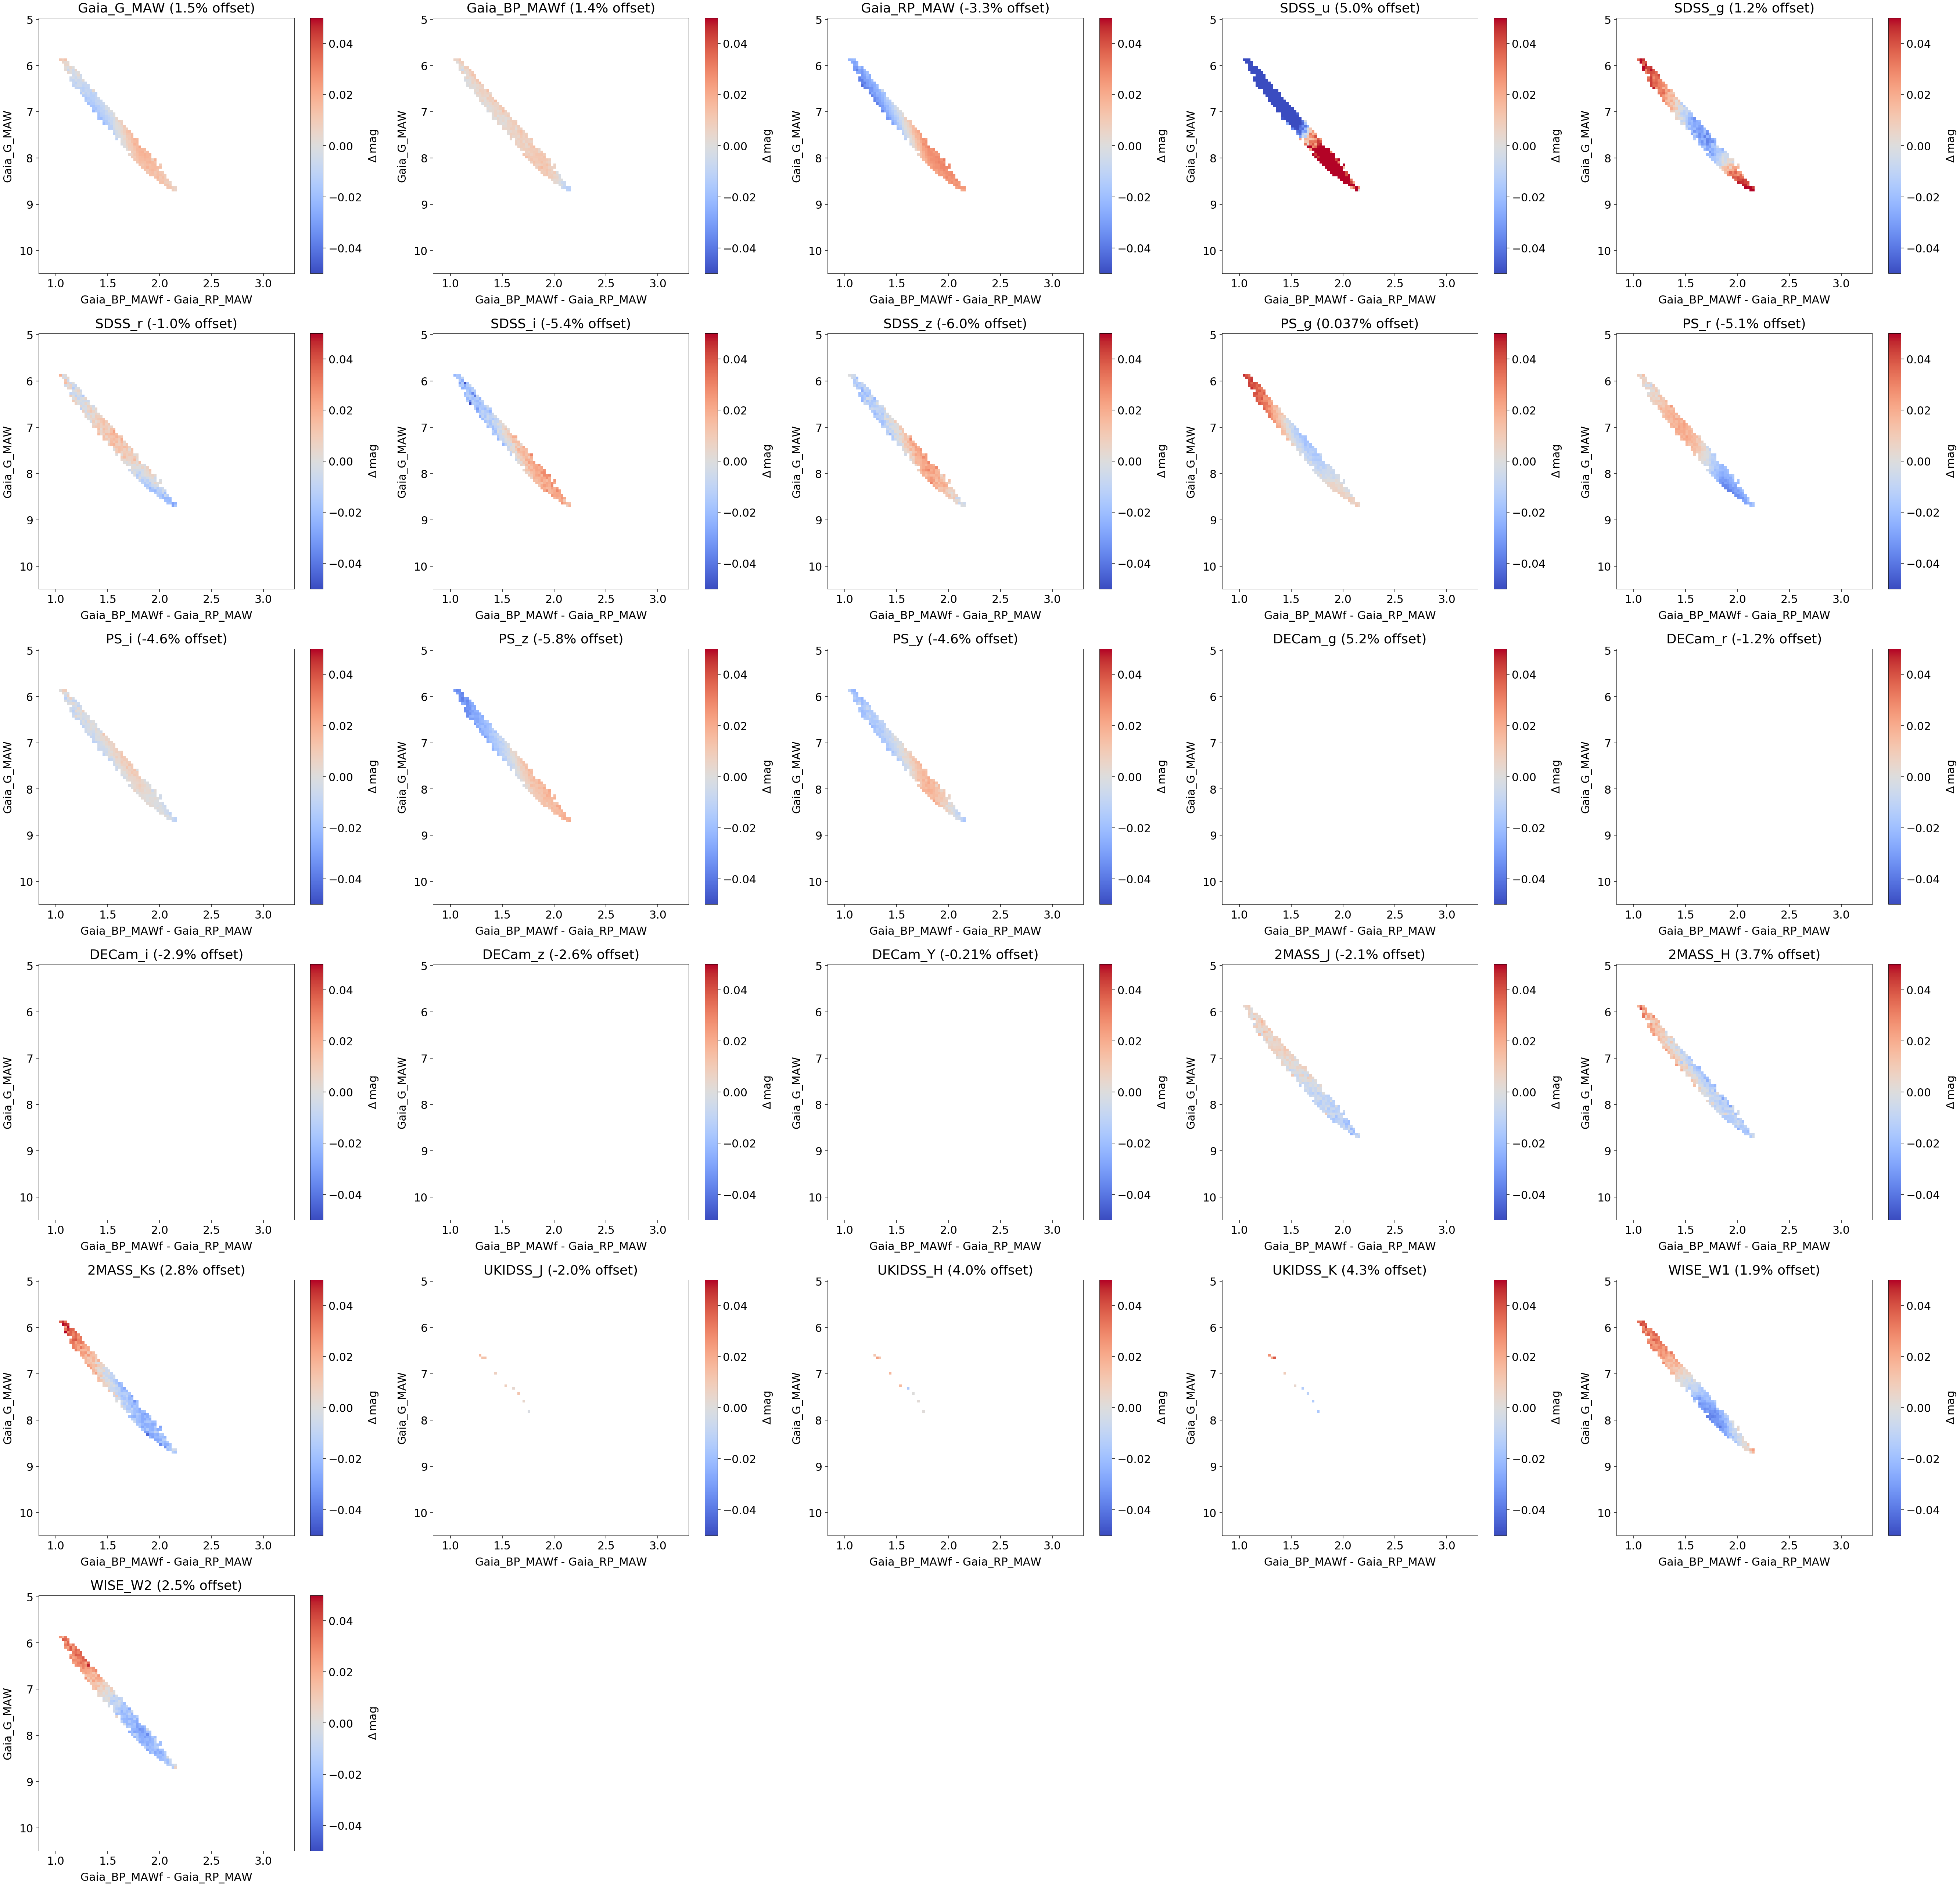

In [24]:
bins = 100  # number of bins
bins_min = 20.  # minimum number of objects to plot bin

# photometric offsets
fig, ax = bplot.photometric_offsets_2d(phot, err, mask,
                                       models_mist, idxs_mist, reds_mist, dreds_mist, dists_mist,
                                       (bp-rp)[sel], g[sel],  # color and magnitude
                                       bins=bins, plot_thresh=bins_min, 
                                       offset=off,
                                       titles=filters,
                                       xlabel=flt.gaia[1]+' - '+flt.gaia[2],
                                       ylabel=flt.gaia[0])
[a.set_ylim(a.get_ylim()[::-1]) for a in ax.flatten()];